In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [2]:
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
DataPath = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/'


dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))

In [4]:
print(masks[:10],images[:10])

['TCGA_DU_7010_19860307_56_mask.tif', 'TCGA_DU_7010_19860307_8_mask.tif', 'TCGA_DU_7010_19860307_34_mask.tif', 'TCGA_DU_7010_19860307_33_mask.tif', 'TCGA_DU_7010_19860307_43_mask.tif', 'TCGA_DU_7010_19860307_39_mask.tif', 'TCGA_DU_7010_19860307_7_mask.tif', 'TCGA_DU_7010_19860307_31_mask.tif', 'TCGA_DU_7010_19860307_6_mask.tif', 'TCGA_DU_7010_19860307_38_mask.tif'] ['TCGA_DU_7010_19860307_56.tif', 'TCGA_DU_7010_19860307_8.tif', 'TCGA_DU_7010_19860307_34.tif', 'TCGA_DU_7010_19860307_33.tif', 'TCGA_DU_7010_19860307_43.tif', 'TCGA_DU_7010_19860307_39.tif', 'TCGA_DU_7010_19860307_7.tif', 'TCGA_DU_7010_19860307_31.tif', 'TCGA_DU_7010_19860307_6.tif', 'TCGA_DU_7010_19860307_38.tif']


In [5]:
imagePath_df = pd.DataFrame({'directory':dirs, 'images':images,'masks':masks})
imagePath_df.head(9)

,directory,images,masks
0,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_56.tif,TCGA_DU_7010_19860307_56_mask.tif
1,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_8.tif,TCGA_DU_7010_19860307_8_mask.tif
2,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_34.tif,TCGA_DU_7010_19860307_34_mask.tif
3,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_33.tif,TCGA_DU_7010_19860307_33_mask.tif
4,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_43.tif,TCGA_DU_7010_19860307_43_mask.tif
5,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_39.tif,TCGA_DU_7010_19860307_39_mask.tif
6,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_7.tif,TCGA_DU_7010_19860307_7_mask.tif
7,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_31.tif,TCGA_DU_7010_19860307_31_mask.tif
8,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_6.tif,TCGA_DU_7010_19860307_6_mask.tif


In [6]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [7]:
def UNET(input_img, n_filters = 32, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [8]:
ImgHeight = 256
ImgWidth = 256
input_img = Input((ImgHeight,ImgWidth,3), name='img')
model = UNET(input_img, n_filters=16, dropout=0.2, batchnorm=True)

2022-08-09 13:35:17.174406: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 13:35:17.271543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 13:35:17.272390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 13:35:17.273683: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [9]:
len(imagePath_df['directory'])

3929

## Load Model

In [10]:
import keras
from keras.models import load_model
from sklearn.metrics import confusion_matrix
model.load_weights('../input/modelbrainmriv8/model-brain-mri-v8.h5')

In [11]:
def intersection_mats(mask, bpred):
    
    intersection = np.sum(np.logical_and(mask,bpred))

    union = np.sum(np.logical_or(mask,bpred))
#     smooth = .00001
    mask_sum = (np.sum(np.abs(mask)) + np.sum(np.abs(bpred)))

    print(mask_sum)
    iou = (intersection) / (union)
    dice = 2 * ((intersection)/(mask_sum))

    iou = np.mean(iou)
    dice = np.mean(dice)
    iou = round(iou,2)
    dice = round(dice,2)
    

#     dice2 = (2*tp)/(2*tp+fp+fn)
    return iou,dice

In [12]:
from sklearn.metrics import accuracy_score
    
def confusion_matrs(mask,bpred):

    mask = mask.flatten()
    bpred = bpred.flatten()  
      
    a = confusion_matrix(mask, bpred)
    
    return a
# return accu,a



## Plots

In [13]:
import random
import cv2
import matplotlib.pyplot as plt

def plots():
    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img),cmap = plt.cm.gray)
#     plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(mask)
#     plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred), cmap = plt.cm.gray)
#     plt.title('Prediction')
    plt.subplot(1,4,4)
    plt.imshow(bpred,cmap = plt.cm.gray)
#     plt.title('BinaryPrediction')
    plt.show()
    print("Pred Shape :",np.squeeze(pred).shape )
    
def prints():
    print("Mask Shape :",mask.shape )
    print("Pred after squeeze Shape :",pred.shape)
    print("Mask After rgb2gray Shape :",mask.shape )
    

In [14]:
#     print("Mask Values:", mask )
#     0-1
#     print("Pred Values:", pred )
#    probabilities
Iou = np.array([], dtype=np.float64)
Dice = np.array([], dtype=np.float64)
index = np.array([], dtype=np.int)
accuracy = np.array([], dtype=np.int)
precision = np.array([], dtype=np.int)
Sens=np.array([], dtype=np.float64)
Spec=np.array([], dtype=np.float64)
# Dice2=np.array([], dtype=np.float64)

for i in range(50):
#     800
    
    idx = random.randint(0,len(imagePath_df['directory']))
    index=np.append(index,idx)
    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])
    

    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    img = cv2.resize(image,(ImgHeight,ImgWidth))
    img = img/255
    img = img[np.newaxis,:,:,:]
#     print("Image Shape :",img.shape )
    
    """The first dimension is the batch size. If you are feeding 1 image at a time you can simply make the first dimension 1 and 
    it doesn't change your data any, just changes the indexing to 4"""
    pred = model.predict(img)
    
#     pred = np.asarray(pred)
    bpred = np.array(np.squeeze(pred) > 0.45,dtype = np.uint8)
    
#     Visualize images

    mask = np.asarray(mask) #(1,256, 256, 3)
    mask = np.squeeze(np.squeeze(mask))#(256, 256, 3)\
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask=mask/255
    
    pred = np.squeeze(pred)
    bpred = np.asarray(bpred) #(256, 256)
    #Make a binary prediction     
    pred = cv2.normalize(pred, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)    
    #     pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)
    
#     plots()

    iou,dice = intersection_mats(mask, bpred)
    
    Iou = np.append(Iou, iou)
    Dice = np.append(Dice,dice)

    
    a =  confusion_matrs(mask,bpred)
    
    if np.size(a)==1:
        
        accu=0;
        pre=0;
        sens=0;
        spec=1;

    else:


        TN = a[0][0];
        FN = a[1][0];
        TP = a[1][1];
        FP = a[0][1];


        pre = (TP)/(TP+FP+0.001)
        accu = (TP+TN)/(TN+TP+FP+FN+0.001)
        sens = (TP)/(TP+FN)
        spec = (TN)/(TN+FP)

        accu =round(accu,2)
        pre = round(pre,2)
        sens = round(sens,2)
        spec = round(spec,2)
#         print(TP,FN,TN,FP)
    
    
    accuracy = np.append(accuracy,accu)
    precision = np.append(precision,pre)
    Spec = np.append(Spec,spec)
    Sens = np.append(Sens,sens)


#     print("confusion matrix:",a)

#     Dice2 = np.append(Dice2,dice2)
#     prints()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informatio

0.0
0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


0.0
4123.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


240.0
0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in long_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


6259.0
0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


2935.0
0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


0.0
53.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in long_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


0.0
0.0
5694.0
0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in long_scalars


2380.0
0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


1520.0
96.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in long_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


0.0
4609.0
0.0
0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


0.0
0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


5447.0
5917.0
0.0
1789.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


0.0
0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


53.0
0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


0.0
0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


8561.0
0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


0.0
191.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in long_scalars


1147.0
4011.0
6.0
0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in long_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


4662.0
0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


4157.0
0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


2002.0
0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [15]:
print(np.size(accuracy),np.size(precision),np.size(Sens), np.size(Spec))
# accuracy,precision, Sens, Spec
# precision
print(a)
print(np.size(a,0))

50 50 50 50
[[65536]]
1


In [16]:
# TP = a[1][1]
# FP = a[0][1]

# precision = (TP)/(TP+FP)
a = np.array([[400, 200],
            [600, 700]
             ])
np.size(a,1)

# print(accuracy,precision,Spec,Sens)

#Proof about dice = 0

intersection = np.sum(np.logical_and(mask,bpred))

union = np.sum(np.logical_or(mask,bpred))

smooth = .01
mask_sum = (np.sum(np.abs(mask)) + np.sum(np.abs(bpred)))

print(mask_sum)
iou = (intersection + smooth) / (union + smooth)
dice = 2* ((intersection + smooth)/(mask_sum + smooth))
print(union,mask_sum)
print(dice)

0.0
0 0.0
2.0


In [17]:
df = pd.DataFrame({'Jacard':Iou, 'Dice_Coef':Dice, 'Accuracy':accuracy, 'Specificity':Spec,'Sensitivity':Sens})
df

,Jacard,Dice_Coef,Accuracy,Specificity,Sensitivity
0,NaN,NaN,0.00,1.00,0.00
1,NaN,NaN,0.00,1.00,0.00
2,NaN,NaN,0.00,1.00,0.00
3,0.72,0.84,0.99,0.99,0.96
4,0.00,0.00,1.00,1.00,NaN
5,NaN,NaN,0.00,1.00,0.00
6,0.64,0.78,0.98,0.98,0.88
7,NaN,NaN,0.00,1.00,0.00
8,0.77,0.87,0.99,1.00,0.91
9,NaN,NaN,0.00,1.00,0.00


In [18]:
df = pd.DataFrame({'Jacard':Iou, 'Dice_Coef':Dice, 'Accuracy':accuracy,'Precision':precision, 'Specificity':Spec,'Sensitivity':Sens})
# 
# 'Dice_Coef_2':Dice2,
df = df.dropna()
indice = df[(df['Jacard']==0)].index
df.drop(indice, inplace=True)

print("Jacard Mean: {m}. Jacard STD: {s}.".format(m = round(df['Jacard'].mean(),2) ,s = round(df['Jacard'].std(),2)))
print("Dice_Coef Mean: {m}. Dice_Coef STD: {s}.".format(m = round(df['Dice_Coef'].mean(),2),s = round(df['Dice_Coef'].std(),2)))
print("Accuracy Mean: {m}. Accuracy STD: {s}.".format(m = round(df['Accuracy'].mean(),2),s = round(df['Accuracy'].std(),2)))
# print("Precision Mean: {m}. Precision STD: {s}.".format(m = round(df['Precision'].mean(),2),s = round(df['Precision'].std(),2)))
print("Specificity: {m}. Specificity STD: {s}.".format(m = round(df['Specificity'].mean(),2),s = round(df['Specificity'].std(),2)))
print("Sensitivity: {m}. Sensitivity STD: {s}.".format(m = round(df['Sensitivity'].mean(),2),s = round(df['Sensitivity'].std(),2)))


# sthlh (1-MASKA) / (0-OXI MASKA) +++ PLHROFORIA APO DATA.CSV +++
# df.to_csv("metric-results_v2.csv",index=False)
df

Jacard Mean: 0.72. Jacard STD: 0.12.
Dice_Coef Mean: 0.83. Dice_Coef STD: 0.08.
Accuracy Mean: 0.99. Accuracy STD: 0.0.
Specificity: 1.0. Specificity STD: 0.01.
Sensitivity: 0.83. Sensitivity STD: 0.16.


,Jacard,Dice_Coef,Accuracy,Precision,Specificity,Sensitivity
3,0.72,0.84,0.99,0.75,0.99,0.96
6,0.64,0.78,0.98,0.70,0.98,0.88
8,0.77,0.87,0.99,0.83,1.00,0.91
14,0.74,0.85,0.99,0.74,0.99,0.99
18,0.69,0.82,1.00,0.99,1.00,0.69
21,0.67,0.80,0.99,0.69,0.99,0.97
26,0.85,0.92,0.99,0.95,1.00,0.89
27,0.92,0.96,1.00,0.94,1.00,0.97
29,0.43,0.61,0.99,0.99,1.00,0.44
36,0.88,0.93,0.99,0.89,0.99,0.99


(256, 256, 3) (256, 256) (256, 256) (256, 256)
uint8 float64 float32 uint8
0


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 256 BarContainer objects>)

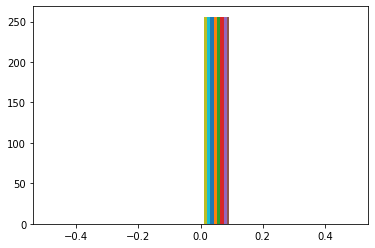

In [19]:
# Investigate the low dice coef 

print(image.shape,mask.shape, pred.shape, bpred.shape)
print(image.dtype,mask.dtype, pred.dtype, bpred.dtype)
print(np.sum(mask==255))
# print(np.sum(bpred==0.9))
mask=mask/255
c=np.round(mask-bpred)
plt.hist(c)

## Boxplots

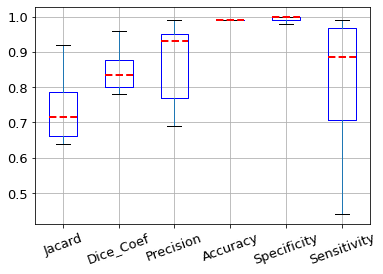

In [20]:
# Plot boxplot
boxprops = dict(linestyle='-', color='blue')
medianprops = dict(linestyle= '--',linewidth='2', color='r')
fig,ax  = plt.subplots()

boxplot = df.boxplot(column=['Jacard','Dice_Coef','Precision', 'Accuracy','Specificity','Sensitivity'],rot=20, fontsize=13,
                    medianprops=medianprops, boxprops=boxprops,showfliers=False, showmeans=False)
plt.show()



In [21]:
image=[]
masks=[]
for idx in index:
#     print(idx)
    
    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    image.append(imagePath)
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])
    masks.append(maskPath)

df = pd.DataFrame({'images':image,'masks':masks})
# print(df['images'][790])
# print(df['masks'][790])

# df = pd.DataFrame({'image':image,'mask':mask})
df

,images,masks
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
5,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
6,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
8,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
9,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


(256, 256, 3)
Number of TP: 48430.666666666664
(256, 256, 3)
Number of TP: 37868.333333333336
(256, 256, 3)
Number of TP: 63869.333333333336
(256, 256, 3)
Number of TP: 48238.333333333336
(256, 256, 3)
Number of TP: 63239.333333333336
(256, 256, 3)
Number of TP: 42283.0
(256, 256, 3)
Number of TP: 16342.0
(256, 256, 3)
Number of TP: 43010.666666666664
(256, 256, 3)
Number of TP: 57547.0
(256, 256, 3)
Number of TP: 38493.333333333336


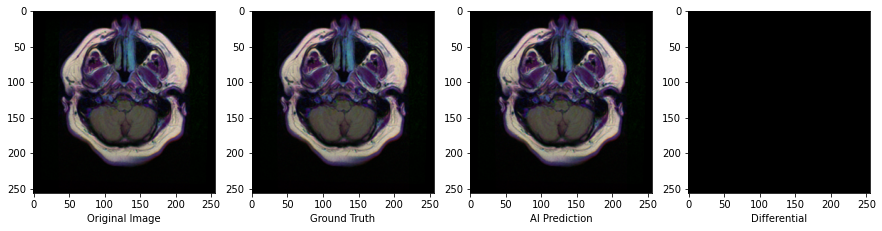

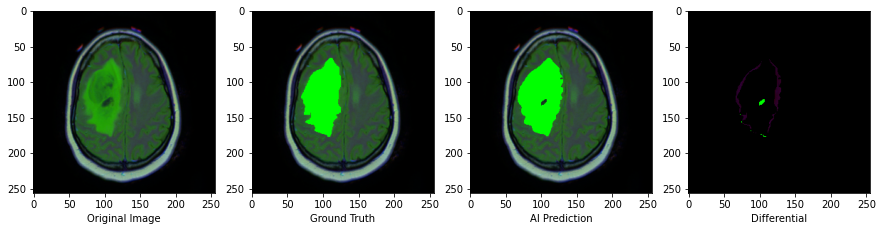

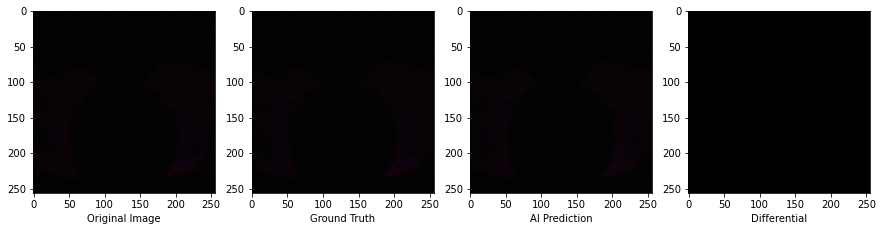

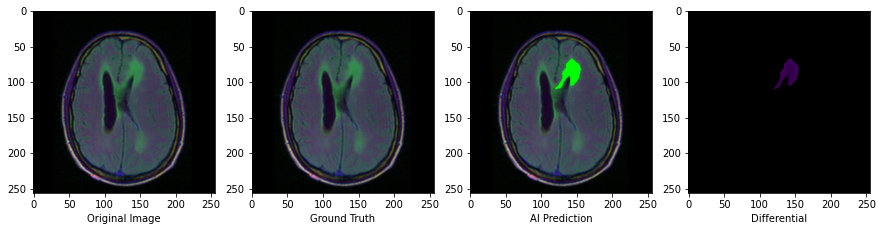

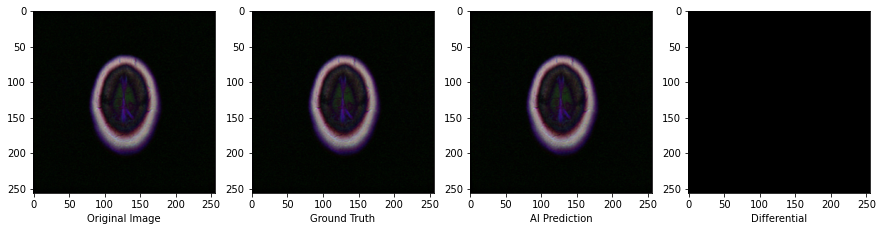

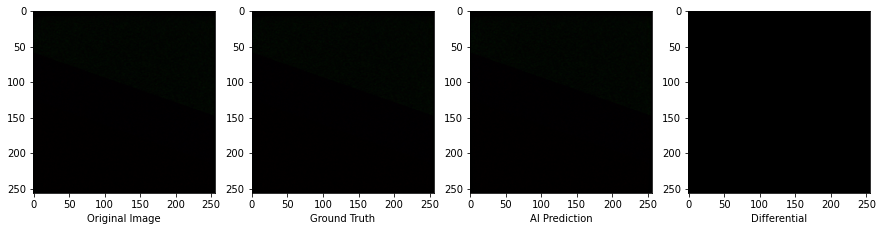

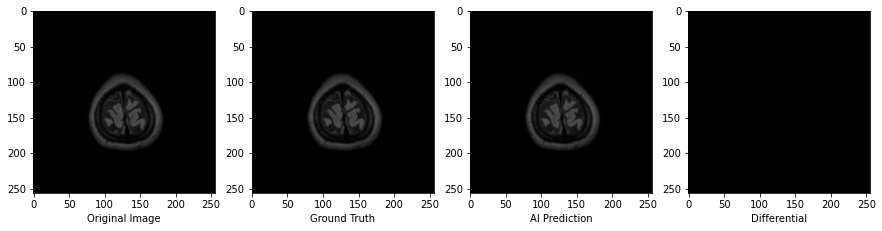

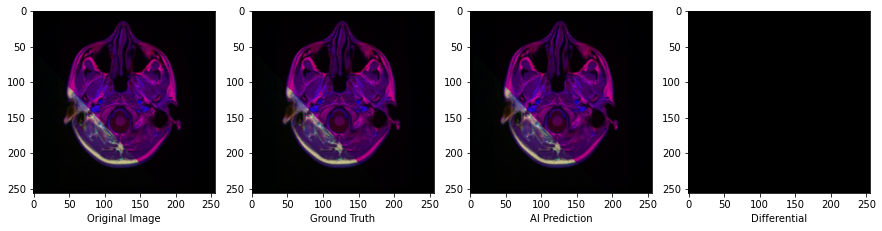

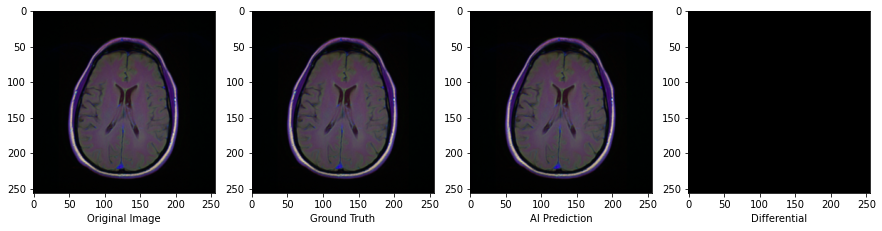

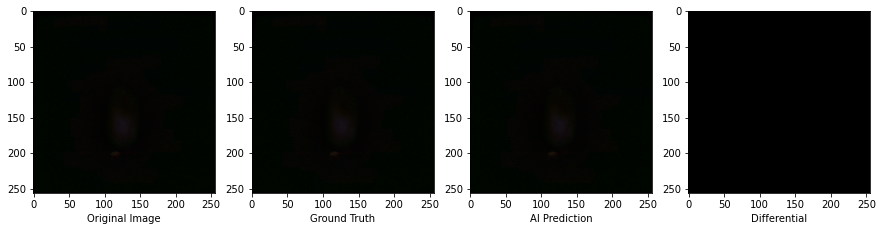

In [22]:

for i in range(10):
    
    """Run it before run the above code . Else not working"""
    index = random.randint(0,len(imagePath_df))
    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[index], imagePath_df['images'].iloc[index])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[index], imagePath_df['masks'].iloc[index])
    
    
    img = cv2.imread(imagePath)
    print(img.shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = cv2.resize(img ,(ImgHeight,ImgWidth))
    img = img / 255
    img = img[np.newaxis, :, :, :]
   
    pred=model.predict(img)
    img = np.squeeze(img)
    
    #Plot Original MRI Scans
    original = img.copy()
    fig, ax = plt.subplots(1,4,figsize = (15,5))
    ax[0].imshow(original,cmap = plt.cm.gray)
    ax[0].set_xlabel('Original Image')
    
    #Plot MRI Scans with their masks
    main = original.copy()
    label = cv2.imread(maskPath)
    sample = np.array(np.squeeze(label), dtype = np.uint8)
    
    contours, hier = cv2.findContours(sample[:,:,0],cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sample_over_gt = cv2.drawContours(main, contours, -1,[0,255,0], thickness=-1)
    ax[1].imshow(sample_over_gt,cmap = plt.cm.gray)
    ax[1].set_xlabel('Ground Truth')
    
    #Plot MRI Predicted Masks
    main = original.copy()
    sample = np.array(np.squeeze(pred) > 0.5, dtype = np.uint8)
    
    contours, hier = cv2.findContours(sample,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sample_over_pr = cv2.drawContours(main, contours, -1, [0,255,0], thickness=-1)
    ax[2].imshow(sample_over_pr, cmap = plt.cm.gray)
    ax[2].set_xlabel("AI Prediction")
    
#     #Plot Difference : MRI Mask - MRI UNET Prediciton
#     #FN
    diff = sample_over_gt - sample_over_pr
    ax[3].imshow(diff)
    ax[3].set_xlabel('Differential')
#     print("Number of pixels :",round(abs(diff.sum())))
    
#     #TP
#      tn, fp, fn, tp = get_confusion_matrix_elements(sample_over_gt,sample_over_pr)
    intersection = np.logical_and(sample_over_gt,sample_over_pr)
    print("Number of TP:",(np.sum(intersection>0.5)/3))
#     image_shape = 256*256
#     print("Number of Total pixels:", image_shape)
    


plt.show()

## Grad-Cam

In [23]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path,  grayscale=False , target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


 ## GradCam 

In [24]:
def make_gradcam_heatmap(image,gradModel):  
    
    # record operations for automatic differentiation
    cls = 0 # first class output probability
    with tf.GradientTape() as tape:
        (convOutputs, predictions) = gradModel(image)
        loss = predictions[:, cls]
    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    convOutputs.shape

#     grads.shape

    output, grads_val = convOutputs[0, :], grads[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))
#     weights.shape

#     output.shape
    cam = np.dot(output, weights)
    cam.shape

    # Process CAM
    cam = cv2.resize(cam, (256, 256), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    cam.shape

    return cam

In [25]:
from IPython.display import Image, display

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.5):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))




(256, 256, 3)


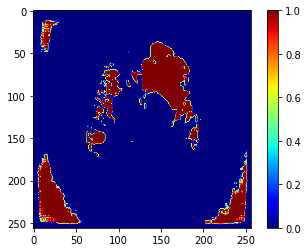

In [26]:
index = random.randint(0,len(imagePath_df))
imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[index], imagePath_df['images'].iloc[index])
image = cv2.imread(imagePath)
plt.imshow(image)

img_height=256
img_width = 256
post_image = get_img_array(imagePath, (img_height, img_width,3))
print(image.shape)
predictions = model.predict(post_image)
last_conv_layer_name = 'conv2d_18'
conv_output = model.get_layer(last_conv_layer_name).output
gradModel = Model(
            inputs=[model.inputs],
            outputs=[conv_output,model.output])

cam = make_gradcam_heatmap(post_image, gradModel)
plt.imshow(cam, cmap='jet')
plt.colorbar()

## Superimposed

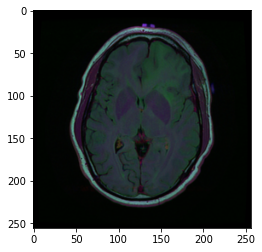

In [27]:
plt.imshow(image)

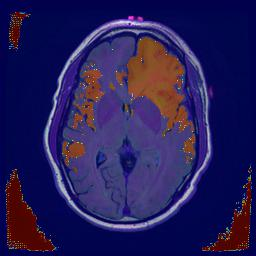

In [28]:
save_and_display_gradcam(imagePath, cam)